In [1]:
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

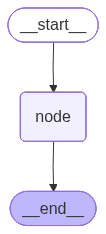

In [3]:
import uuid
from typing import Optional
from typing_extensions import TypedDict
from IPython.display import Image, display

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command


class State(TypedDict):
    """The graph state."""

    foo: str
    human_value: Optional[str]
    """Human value will be updated using an interrupt."""


def node(state: State):
    answer = interrupt(
        # This value will be sent to the client
        # as part of the interrupt information.
        "what is your age?"
    )
    print(f"> Received an input from the interrupt: {answer}")
    return {"human_value": answer}


builder = StateGraph(State)
builder.add_node("node", node)
builder.add_edge(START, "node")

# A checkpointer must be enabled for interrupts to work!
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)
display(Image(graph.get_graph().draw_mermaid_png()))


In [4]:

config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}

for chunk in graph.stream({"foo": "abc"}, config):
    print(chunk)

# > {'__interrupt__': (Interrupt(value='what is your age?', id='45fda8478b2ef754419799e10992af06'),)}


{'__interrupt__': (Interrupt(value='what is your age?', id='fcdeabfb12f0178dd4a634a9159ab306'),)}


In [5]:
command = Command(resume="some input from a human!!!")

for chunk in graph.stream(command, config):
    print(chunk)

# > Received an input from the interrupt: some input from a human!!!
# > {'node': {'human_value': 'some input from a human!!!'}}

> Received an input from the interrupt: some input from a human!!!
{'node': {'human_value': 'some input from a human!!!'}}
